In [24]:
# What version python do you have 
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )



GPU is available


In [25]:
#Semilla 
tf.random.set_seed(0)

In [26]:
#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

#Número de Puntos
N_r = 2000

## 0. Carga de Datos

In [64]:
input_vessel_1 = np.load("input_1.npy", allow_pickle=True).item()
output_vessel_2 = np.load("output_2.npy", allow_pickle=True).item()
output_vessel_3 = np.load("output_3.npy", allow_pickle=True).item()
        
velocity_measurements_vessel1 = input_vessel_1["Velocity"][:,None]
velocity_measurements_vessel2 = output_vessel_2["Velocity"][:,None]
velocity_measurements_vessel3 = output_vessel_3["Velocity"][:,None]
    
area_measurements_vessel1 = input_vessel_1["Area"][:,None]
area_measurements_vessel2 = output_vessel_2["Area"][:,None]
area_measurements_vessel3 = output_vessel_3["Area"][:,None]

t = input_vessel_1["Time"][:,None]
t_min_mesurement = t.min()

N_u = len(t)

#Medicions del area y de la velocidad a la entrada del vaso
u_in =  tf.constant(velocity_measurements_vessel1 , dtype = DTYPE)
A_in = tf.constant(area_measurements_vessel1 , dtype = DTYPE)


## 1. Configuración de Dominios 

In [28]:
#Dominio 1
tmin = 0 
tmax = 3.3
xmin_1 = 0
xmax_1 = 3
#xmax_1 = 0.1703

#Cotas Inferiores
lb = tf.constant([tmin, xmin_1], dtype = DTYPE)

#Cotas Superiores
ub = tf.constant([tmax, xmax_1], dtype = DTYPE)

#Dibujo de un muestreo uniforme de los puntos de colocación
x_r1 = tf.random.uniform((N_r,1), lb[1], ub[1], dtype = DTYPE)
t_r1 = tf.random.uniform((N_r,1), lb[0], ub[0], dtype = DTYPE)
X_r1 = tf.concat([x_r1, t_r1], axis = 1) #Muestreo aleatorio simple en el cuadrado [0,0.1703] x [0,3.3]

#Condición de Borde 
x_in =tf.ones((N_u,1), dtype = DTYPE)*0
t_0 = tf.constant(t , dtype = DTYPE)
X_b1 = tf.concat([x_in, t_0], axis = 1) 

#Condición Inicial 
X_vessel1 = np.linspace(xmin_1, xmax_1, N_u)[:,None]
X_initial_vessel1 = tf.constant(X_vessel1 , dtype = DTYPE)
t_inicial =tf.ones((N_u,1), dtype = DTYPE)*t_min_mesurement
X_01 = tf.concat([X_initial_vessel1, t_inicial], axis = 1) 


Text(0.5, 1.0, 'Posición de los puntos de colocación y datos de borde')

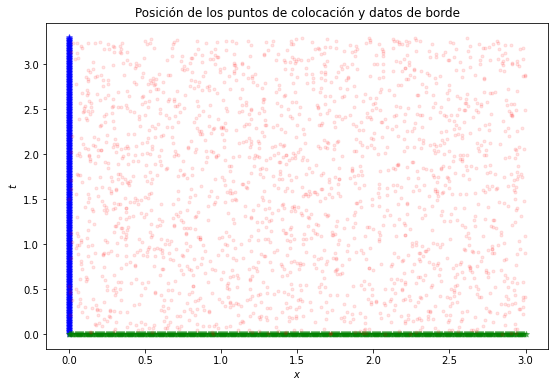

In [29]:
#Gráfica de los puntos de colocación
fig = plt.figure(figsize = (9,6))
plt.scatter( x_in, t_0 , c= 'b', marker = '*', alpha = 0.5)
plt.scatter( X_initial_vessel1, t_inicial , c= 'g', marker = '*', alpha = 0.5)
plt.scatter( x_r1, t_r1, c = 'r', marker = '.', alpha = 0.1)
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Posición de los puntos de colocación y datos de borde')

## 3. Configuración de la Arquitectura de la Red Neuronal

In [30]:
#Configuración Red Neuronal
def init_model(num_hidden_layers = 2, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))
    
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    model.add(tf.keras.layers.Dense(3))
    
    return model

## 4. Definir rutina para determinar la perdida y los gradientes

In [31]:
#Condiciones iniciales
p_ext = 0 
beta =  6
A_0 = 3.0E1  
rho = 10

#p_ext = 0 
#beta =  69673881.97
#A_0 = 1.35676200E-05 
#rho = 1000

In [32]:
#Definición funcion residual PDE
def fun_r1A(t, x, u, u_x, A, A_t, A_x):
    return A_t + u * A_x + A * u_x    

def fun_r1u(t, x, u, u_t, u_x, p_x):
    return u_t + u * u_x  + (1/rho) * p_x   

def fun_r1p(t, x, p, A):
    return (p - p_ext + beta*(tf.sqrt(A_0)))**2 - A*(beta**2)    

In [33]:
def get_r(model, X_r):
    with tf.GradientTape(persistent = True) as tape:
        t, x = X_r[:, 0:1], X_r[:,1:2]
        tape.watch(t)
        tape.watch(x)
        
        A = model(tf.stack([t[:,0], x[:,0]], axis = 1))[:,0:1]  #concat tambien funciona
        u = model(tf.stack([t[:,0], x[:,0]], axis = 1))[:,1:2] 
        p = model(tf.stack([t[:,0], x[:,0]], axis = 1))[:,2:3] 
 

    A_t = tape.gradient(A,t)
    A_x = tape.gradient(A,x)    
    u_t = tape.gradient(u,t)
    u_x = tape.gradient(u,x)
    p_x = tape.gradient(p,x)
    
    del tape
    
    return [fun_r1A(t, x, u, u_x, A, A_t, A_x), fun_r1u(t, x, u, u_t, u_x, p_x), fun_r1p(t, x, p, A)]

In [34]:
#Calculo del a funcion loss de nuestro modelo

#def compute_loss(model, X_r, X_data, u_data):
def compute_loss(model, X_r, X_0):
    r_A = get_r(model, X_r)[0]
    r_u = get_r(model, X_r)[1]
    r_p = get_r(model, X_r)[2]
    
    phi_r_A = tf.reduce_mean(tf.square(r_A))
    phi_r_u = tf.reduce_mean(tf.square(r_u))
    phi_r_p = tf.reduce_mean(tf.square(r_p))
    

    loss = phi_r_A + phi_r_u + phi_r_p  #inicializar loss
    
    #agregando componente borde e inicial
    xx0, tt0 = X_0[:, 0:1], X_0[:,1:2]
    #for i in range(len(X_0)):
    u_pred = model(tf.stack([xx0[:,0], tt0[:,0]], axis = 1))[:,1:2]
    loss += tf.reduce_mean(tf.square(0 - u_pred))
    
    return loss

In [35]:
#Calculo de gradientes de la función de pérdida

#def get_grad(model, X_r, X_data, u_data):
def get_grad(model, X_r, X_0):
    with tf.GradientTape(persistent = True) as tape:
        
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_0)
        #loss = compute_loss(model, X_r, X_data, u_data)
        
    g = tape.gradient(loss, model.trainable_variables)
    
    del tape
    
    return loss, g

## 5. Configuración del Optimizador y Entrenamiento del Modelo

In [36]:
#Inicializacion del modelo
model_1 = init_model()

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000], [1e-2, 1e-3, 5e-4])

#Eleccion del Optimizador
optim = tf.keras.optimizers.Adam(learning_rate = lr)

In [57]:
from time import time 

@tf.function 
def train_step():
    loss, grad_theta = get_grad(model_1, X_r1, X_01)
    #loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    #Realizar paso del descenso de gradiente
    optim.apply_gradients(zip(grad_theta, model_1.trainable_variables))
    
    return loss

#Número de Épocas
N = 500
hist = []

#Comienzo del tiempo
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    hist.append(loss.numpy())
    
    #Salida después de 50 iteraciones
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'. format(i,loss))
        
#Mostrar tiempo de calculo 
print('\nComputation time: {} seconds'.format(time()-t0))

2022-08-14 15:14:33.331574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 8.36777306e+00
It 00050: loss = 8.31275558e+00
It 00100: loss = 8.25639629e+00
It 00150: loss = 8.19867897e+00
It 00200: loss = 8.13960361e+00
It 00250: loss = 8.07924366e+00
It 00300: loss = 8.01762772e+00
It 00350: loss = 7.95480204e+00
It 00400: loss = 7.89082241e+00
It 00450: loss = 7.82570267e+00
It 00500: loss = 7.75948811e+00

Computation time: 9.134423017501831 seconds


## 6. Gráfica

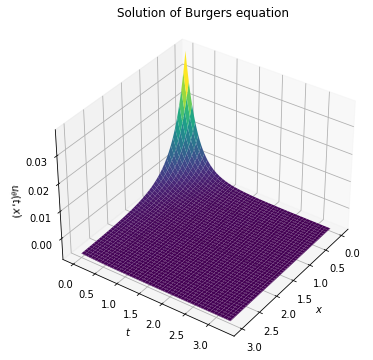

In [60]:
from mpl_toolkits.mplot3d import Axes3D

tmin = 0 
tmax = 3.3
xmin_1 = 0
xmax_1 = 3

# Set up meshgrid
N = 600
xspace = np.linspace(xmin_1, xmax_1, N + 1)
tspace = np.linspace(tmin, tmax, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T


# Determine predictions of u(t, x)
upred = model_1(tf.cast(Xgrid,DTYPE))[:,1:2]

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

## Verificaciones

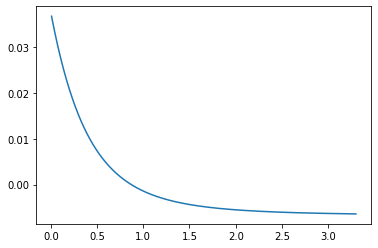

In [59]:
plt.plot(t_0,uu)

In [58]:
xx, tt = X_01[:, 0:1], X_01[:,1:2]
uu = model_1(tf.stack([xx[:,0], tt[:,0]], axis = 1))[:,1:2]
uu

<tf.Tensor: shape=(413, 1), dtype=float32, numpy=
array([[ 3.68054509e-02],
       [ 3.59748602e-02],
       [ 3.51608992e-02],
       [ 3.43635082e-02],
       [ 3.35819125e-02],
       [ 3.28159928e-02],
       [ 3.20653915e-02],
       [ 3.13302875e-02],
       [ 3.06098461e-02],
       [ 2.99037695e-02],
       [ 2.92120576e-02],
       [ 2.85341740e-02],
       [ 2.78700590e-02],
       [ 2.72195935e-02],
       [ 2.65821218e-02],
       [ 2.59575248e-02],
       [ 2.53454447e-02],
       [ 2.47459412e-02],
       [ 2.41586566e-02],
       [ 2.35831738e-02],
       [ 2.30194330e-02],
       [ 2.24668980e-02],
       [ 2.19258070e-02],
       [ 2.13955641e-02],
       [ 2.08759904e-02],
       [ 2.03672051e-02],
       [ 1.98684335e-02],
       [ 1.93798542e-02],
       [ 1.89012289e-02],
       [ 1.84322596e-02],
       [ 1.79727077e-02],
       [ 1.75225735e-02],
       [ 1.70813799e-02],
       [ 1.66491866e-02],
       [ 1.62255764e-02],
       [ 1.58107281e-02],
       [ 1.540